In [8]:
import os
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

In [13]:
data_path = os.path.join(os.getcwd(), "dataset_with_populations.csv")
print(data_path)

/Users/gautam/Downloads/KU_Leuven_Bioinformatics_Masters/datathon_ambulance/dataset_with_populations.csv


In [48]:
# Read data
data = pd.read_csv(data_path)
#X, y = data.data, data.target
data = data.iloc[:, 1:8]
data = data.iloc[:, data.columns != 'municipality']
#data

X = data.drop(columns = ['postal_code', 'DOA_cardiac'])
y = data['DOA_cardiac']

In [50]:
# train-test split for model evaluation
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
 
# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [51]:
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32).reshape(-1, 1)

In [57]:
# Define the model
model = nn.Sequential(
    nn.Linear(4, 6), # 5 input variables
    nn.ReLU(),
    nn.Linear(6, 4),
    nn.ReLU(),
    nn.Linear(4, 1) # 1 output (regression)
)

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

batch_size = 10  # size of each batch
n_epochs = int(np.ceil(X_train.shape[0] / 10))
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

In [54]:
n_epochs

21

In [58]:
# Train model
for epoch in range(n_epochs):
    model.train()
    # This next part is just for showing a progress meter; not super important
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

MSE: 0.0027929062489420176
RMSE: 0.05284795406581051


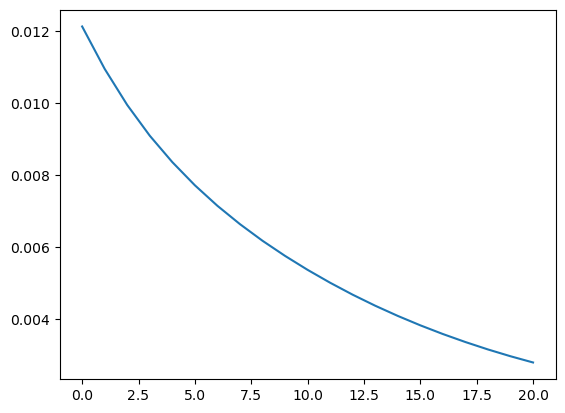

Sequential(
  (0): Linear(in_features=4, out_features=6, bias=True)
  (1): ReLU()
  (2): Linear(in_features=6, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)

In [65]:
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE:", best_mse)
print("RMSE:", np.sqrt(best_mse))
plt.plot(history)
plt.show()

model.eval()
# with torch.no_grad():
#     # Test out inference with 5 samples from the original test set
#     for i in range(5):
#         X_sample = X_test_raw[i: i+1]
#         X_sample = scaler.transform(X_sample)
#         X_sample = torch.tensor(X_sample, dtype=torch.float32)
#         y_pred = model(X_sample)
#         print(f"{X_test_raw[i]} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

In [62]:
y_train

tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.0357],
        [0.0178],
        [0.0000],
        [0.0455],
        [0.0000],
        [0.0000],
        [0.0435],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0132],
        [0.0690],
        [0.0000],
        [0.0459],
        [0.0305],
        [0.0267],
        [0.0072],
        [0.0304],
        [0.0292],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0423],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0184],
        [0.0000],
        [0.0000],
        [0.0377],
        [0.0000],
        [0.0346],
        [0.0000],
        [0.0667],
        [0.0186],
        [0.0625],
        [0.0109],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0421],
        [0.0000],
        [0.0248],
        [0.0000],
        [0.0000],
        [0.0135],
        [0.0195],
        [0.0000],
        [0.0000],
        [0.0303],
        [0

In [ ]:
def score_trained_model(params, args):
    # Get the model from the fixed args.
    model = args[0]

    # Run the model on the params, return the output.
    return model_predict(model, params)

In [ ]:
# Nelder-Mead is my go-to to start with.
# But it doesn't take advantage of the gradient.
# Something that does, e.g. BGFS, may perform better for your case.
method = 'Nelder-Mead'

# All zeros is fine, but improving this initial guess can help.
guess_params = [0]*4

# Given a trained model, optimize the inputs to minimize the output.
optim_params = scipy.optimize.minimize(
    score_trained_model,
    guess_params,
    args=(trained_model,),
    method=method,
)